In [1]:
import torch
import os
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
from PIL import Image, ImageOps
import torch
import pdb
import numpy as np
import yaml
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from template import utils
from torchvision.utils import save_image

import torch.nn.functional as F

In [2]:
# setting config
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    v2.Resize((128, 128))
])

In [4]:
train_dataset = torchvision.datasets.CelebA(root='./data', split='train',
                                        download=True, transform=transform)
valid_dataset = torchvision.datasets.CelebA(root='./data', split='valid',
                                       download=True, transform=transform)
test_dataset = torchvision.datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)

#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Display images from the dataset

In [5]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Image Shapes: torch.Size([64, 3, 128, 128])
Label Shapes: torch.Size([64, 40])


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


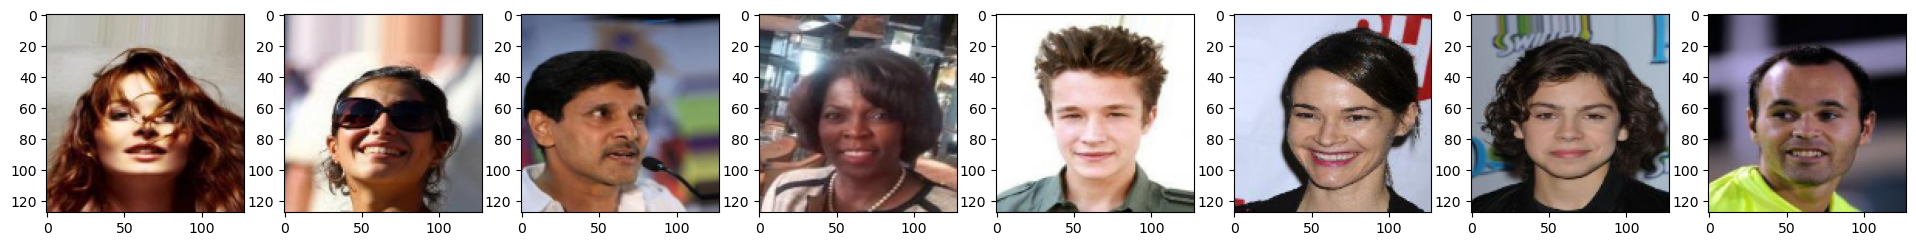

In [6]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,128,128).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

In [5]:
def save_model(model, optimizer, epoch, stats, exp_no = 4):
    """ Saving model checkpoint """
    
    if(not os.path.exists("experiments/experiment_"+str(exp_no)+"/models")):
        os.makedirs("experiments/experiment_"+str(exp_no)+"/models")
    savepath = "experiments/experiment_"+str(exp_no)+f"/models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [6]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        kld_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image(recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png"))
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, writer,savepath="", save_frequency=2):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % save_frequency == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)

        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld

Dropouts + additional conv layers led to brwon pictures, but more details -> did not improve. When only using kernel size = 2 we saw very blocky pictures so we opted for kernel size 3 with a smaller stride. The results were as expected. We lost some of the blockieness. Increasing encoder linear layers did not help   (led to brownness)

In [7]:
class ConvVAE(nn.Module):
    
    def __init__(self):
        super(ConvVAE, self).__init__()

        # Define Convolutional Encoders
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
        )

        # Define mean and variance
        self.mu = nn.Linear(8192, 200)
        
        # Note: we learn the log variance to make training easier (allows negative values)
        self.log_var = nn.Linear(8192, 200)

        # Define decoder
        self.decoder = nn.Sequential(
            nn.Linear(200, 8192),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size=(32, 16, 16)),
            nn.ConvTranspose2d(in_channels = 32, out_channels=32, kernel_size = 3, stride = 2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels = 16, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=3, kernel_size=8, stride = 1, padding = 0),
            nn.ReLU()
        )

    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mu(x)
        log_var = self.log_var(x)

        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, (z, mean, log_var)

test = nn.ConvTranspose2d(3, 16, kernel_size = 3, stride = 2, padding = 0)
cvae = ConvVAE()

x = torch.zeros(32, 200)
cvae.decoder(x).shape

torch.Size([32, 3, 128, 128])

In [7]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    # Deriving kld for vaes: https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cvae = ConvVAE()
criterion = vae_loss_function
optimizer = torch.optim.Adam(cvae.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5, verbose = True)
cvae = cvae.to(device)

In [24]:
savepath = "/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_4"


In [25]:
cvae.load_state_dict(x['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for ConvVAE:
	Unexpected key(s) in state_dict: "encoder.9.weight", "encoder.9.bias". 
	size mismatch for mu.weight: copying a param with shape torch.Size([200, 4096]) from checkpoint, the shape in current model is torch.Size([200, 8192]).
	size mismatch for log_var.weight: copying a param with shape torch.Size([200, 4096]) from checkpoint, the shape in current model is torch.Size([200, 8192]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([4096, 200]) from checkpoint, the shape in current model is torch.Size([8192, 200]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([8192]).
	size mismatch for decoder.3.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([16, 8, 2, 2]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for decoder.9.weight: copying a param with shape torch.Size([8, 3, 2, 2]) from checkpoint, the shape in current model is torch.Size([3, 8, 8, 8]).

In [14]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=cvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=15, savepath=savepath, writer=None)

  0%|          | 0/1272 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [18]:
cvae = load_model(ConvVAE, optimizer=optimizer, savepath = '/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_1/models/checkpoint_epoch_5.pth')

TypeError: Module.load_state_dict() missing 1 required positional argument: 'state_dict'

In [ ]:
eval_model(cvae, validloader, criterion=criterion, device=device)

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

(0.0729166641831398, 0.06857893689029469, 4.337727179481286)

In [ ]:
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 200).to(device)
        sample = cvae.decoder(z)
    

recons = sample.view(64, 3, 128, 128).cpu()

recons.shape

torch.Size([64, 3, 128, 128])

In [ ]:
recons.shape

torch.Size([64, 3, 128, 128])

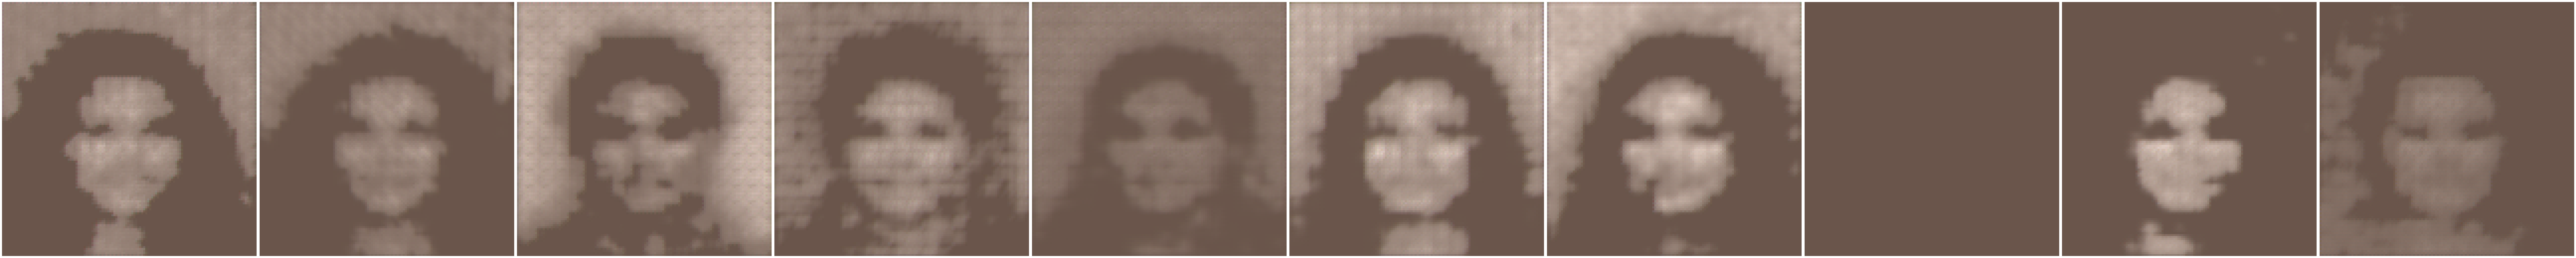

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

for i in range(10):
    img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels for clarity

plt.tight_layout()
plt.show()

In [ ]:
test_data.shape

torch.Size([64, 3, 128, 128])

In [ ]:
sample.shape

AttributeError: 'tuple' object has no attribute 'shape'

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


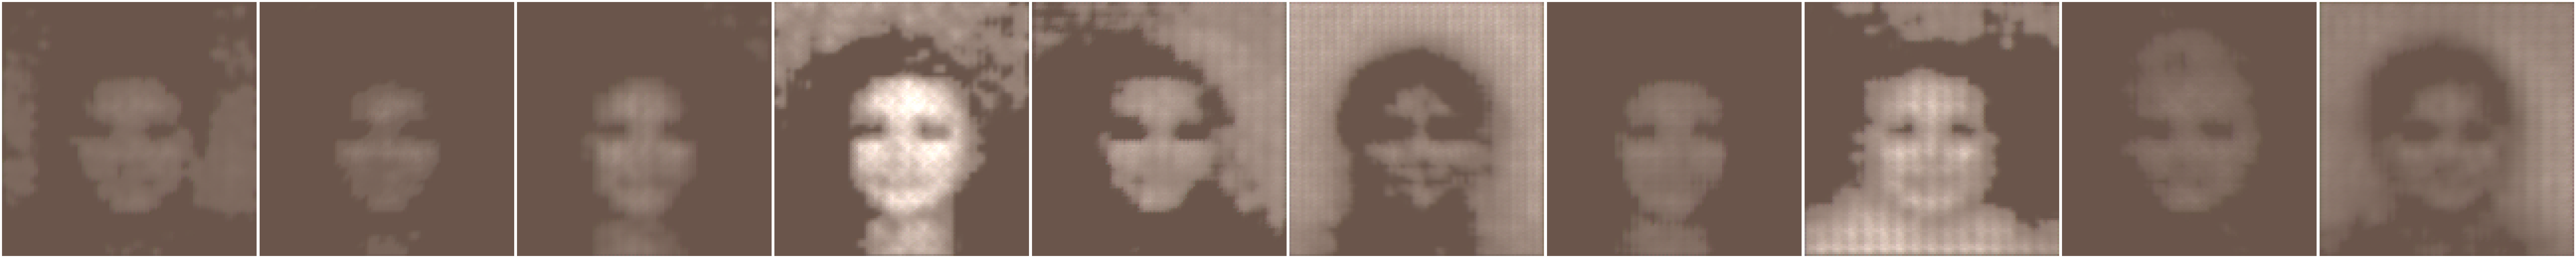

In [ ]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = cvae(test_data)

    recons = sample.view(64, 3, 128, 128).cpu()

    fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()

In [34]:
class ConvNextVAE(nn.Module):
    def __init__(self, latent_dim = 256):
        super(ConvNextVAE, self).__init__()
        
        convnext = torchvision.models.convnext_tiny(weights='DEFAULT')
        print(convnext)
        modules = list(convnext.children())[:-1]  # delete last fc layer, so we could conviniently re-use the decoder
        self.encoder = nn.Sequential(*modules,
                                    nn.Flatten(),
                                    nn.Linear(768, 8192))
        print(self.encoder)
        # Note: 1000 marks the output dim of convnext tiny 
        self.mu = nn.Linear(8192, latent_dim)
        
        # Note: we learn the log variance to make training easier (allows negative values)
        self.log_var = nn.Linear(8192, latent_dim)
        
        # Decoder is re-used thanks to deleting last fc layer in the pretrained convnext encoder.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8192),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size=(32, 16, 16)),
            nn.ConvTranspose2d(in_channels = 32, out_channels=32, kernel_size = 3, stride = 2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels = 16, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=3, kernel_size=8, stride = 1, padding = 0),
            nn.ReLU()
        )
        
        # Pretrained ResNet18 model as the encoder
        # self.encoder = torchvision.models.convnext_tiny(weights='DEFAULT')
        # print(self.encoder)
        # CNN architechtures
#         self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
#         self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
#         self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
#         self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding
#         # encoding components
#         resnet = torchvision.models.resnet152(pretrained=True)
#         modules = list(resnet.children())[:-1]# delete the last fc layer.
#         print(resnet.fc.in_features)
#         self.encoder = nn.Sequential(
#         nn.Sequential(*modules),
#         nn.Flatten(),
#         nn.Linear(resnet.fc.in_features, 1024),
#         nn.BatchNorm1d(1024, momentum=0.01),
#         nn.ReLU(),
#         nn.Linear(1024, 768),
#         nn.BatchNorm1d(768, momentum=0.01),
#         nn.ReLU()
#         )
#         # Define mean and variance
#         # Note: 1000 marks the output dim of convnext tiny 
#         self.mu = nn.Linear(768, latent_dim)
        
#         # Note: we learn the log variance to make training easier (allows negative values)
#         self.log_var = nn.Linear(768, latent_dim)
        
#         self.fc4 = nn.Linear(latent_dim, 768)
#         self.fc_bn4 = nn.BatchNorm1d(768)
#         self.fc5 = nn.Linear(768, 1024)
#         self.fc_bn5 = nn.BatchNorm1d(1024)
#         self.relu = nn.ReLU(inplace=True)
        
#         # Decoder
#         self.convTrans6 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
#                                padding=self.pd4),
#             nn.BatchNorm2d(32, momentum=0.01),
#             nn.ReLU(inplace=True),
#         )
#         self.convTrans7 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
#                                padding=self.pd3),
#             nn.BatchNorm2d(8, momentum=0.01),
#             nn.ReLU(inplace=True),
#         )

#         self.convTrans8 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
#                                padding=self.pd2),
#             nn.BatchNorm2d(3, momentum=0.01),
#             nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 768),
#             nn.BatchNorm1d(768),
#             nn.ReLU(),
#             nn.Linear(768, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Unflatten(dim = 1, unflattened_size=(64, 4, 4)),
#             self.convTrans6,
#             self.convTrans7,
#             self.convTrans8
#         )
        # Parameters of newly constructed modules have requires_grad=True by default
        #self.encoder.classifier[2] = nn.Linear(self.encoder.classifier[2].in_features, latent_dim*2)
    
        
        # Define decoder
        # Note: It is semi-mirrored architecture of convnext tiny (without convblocks)
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, 1000),
        #     nn.ReLU(),
        #     nn.Linear(1000, 768),
        #     nn.ReLU(),
        #     nn.Unflatten(dim = 1, unflattened_size=(768, 1, 1)),
        #     nn.ConvTranspose2d(in_channels = 768, out_channels=384, kernel_size = 2, stride = 2, padding=0),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(in_channels=384, out_channels = 192, kernel_size = 2, stride = 2, padding = 0),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(in_channels = 192, out_channels = 96, kernel_size = 2, stride = 2, padding = 0),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=96, out_channels=3, kernel_size=4, stride = 4, padding = 0),
        #     nn.ReLU()
        # )
        
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
       # x_hat = F.interpolate(x_hat, size=(128, 128), mode='bilinear')
        return x_hat, (z, mu, log_var)

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cNEXTvae = ConvNextVAE(256)
criterion = vae_loss_function
optimizer = torch.optim.Adam(cNEXTvae.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5, verbose = True)
cNEXTvae = cNEXTvae.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [36]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=cNEXTvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=15, writer=None)

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.05588
    Valid loss: 0.27839
       Valid loss recons: 0.27777
       Valid loss KL-D:   0.61115


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04173
    Valid loss: 0.04192
       Valid loss recons: 0.03241
       Valid loss KL-D:   9.51882


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.0405
    Valid loss: 0.0405
       Valid loss recons: 0.03019
       Valid loss KL-D:   10.30615


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04003
    Valid loss: 0.03985
       Valid loss recons: 0.02957
       Valid loss KL-D:   10.27717


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03971
    Valid loss: 0.03969
       Valid loss recons: 0.02964
       Valid loss KL-D:   10.05035


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03949
    Valid loss: 0.03936
       Valid loss recons: 0.02863
       Valid loss KL-D:   10.72838


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03931
    Valid loss: 0.03912
       Valid loss recons: 0.02887
       Valid loss KL-D:   10.2512


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03913
    Valid loss: 0.03897
       Valid loss recons: 0.0287
       Valid loss KL-D:   10.2781
Training completed


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

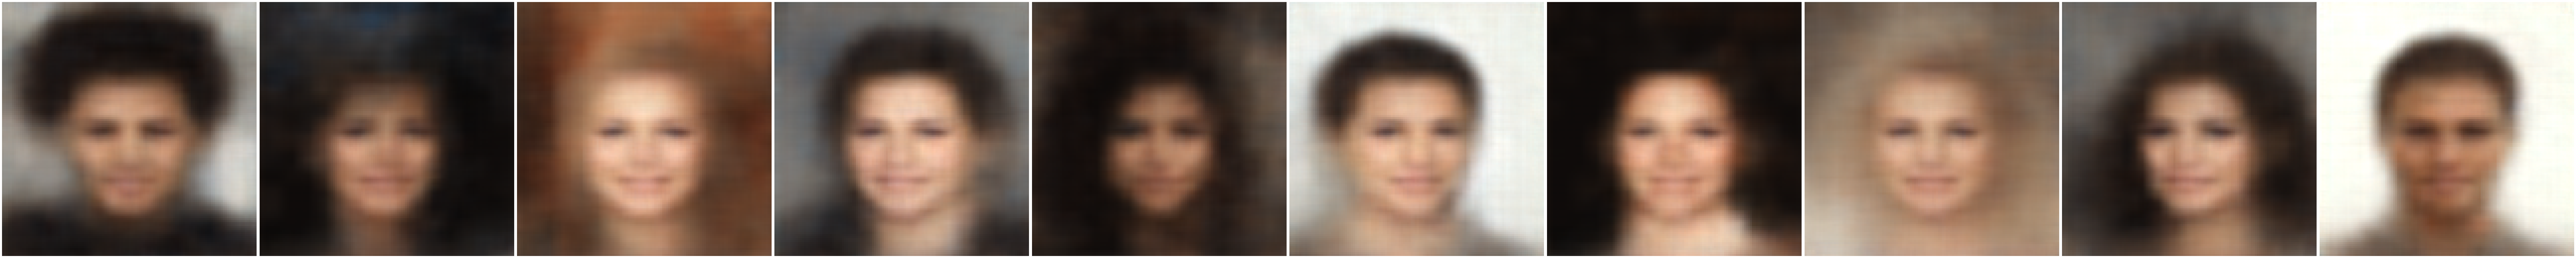

In [37]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = cNEXTvae(test_data)

    recons = sample.view(64, 3, 128, 128).cpu()

    fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()